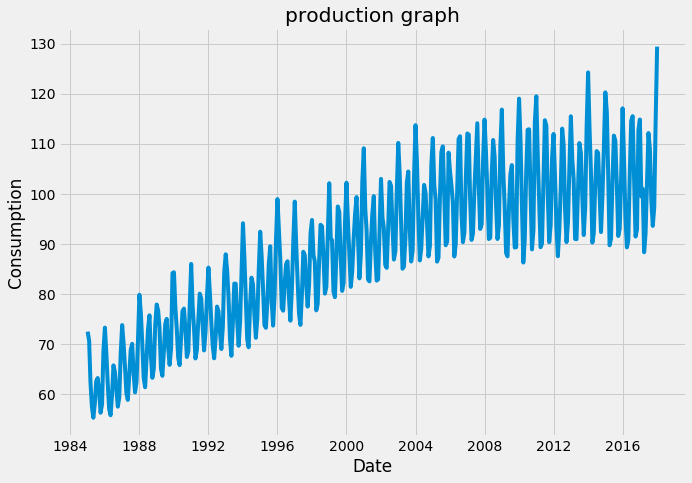

In [20]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 10, 7

df = pd.read_csv("Electric_Production.csv")

df.columns=['Date', 'Consumption']
df=df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #set date as index
df.head()

plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)

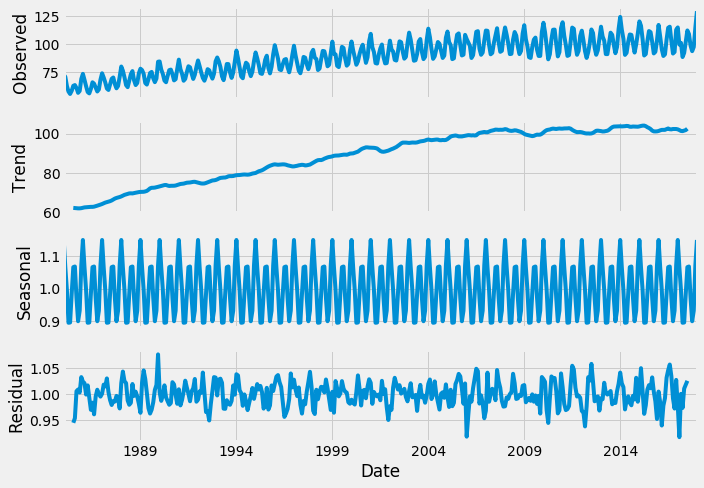

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    '''
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    '''
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df)

Results of dickey fuller test
Test Statistics                 -2.256990
p-value                          0.186215
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


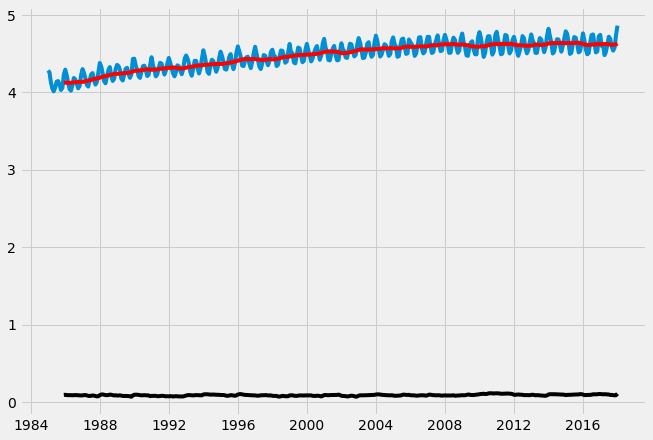

Results of dickey fuller test
Test Statistics                 -5.211586
p-value                          0.000008
No. of lags used                15.000000
Number of observations used    370.000000
critical value (1%)             -3.448148
critical value (5%)             -2.869383
critical value (10%)            -2.570948
dtype: float64


In [8]:
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

test_stationarity(df_log_moving_avg_diff)

weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

In [9]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

logScale_weightedMean = df_log-weighted_average
plt.rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

Results of dickey fuller test
Test Statistics                 -3.251531
p-value                          0.017189
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


Results of dickey fuller test
Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


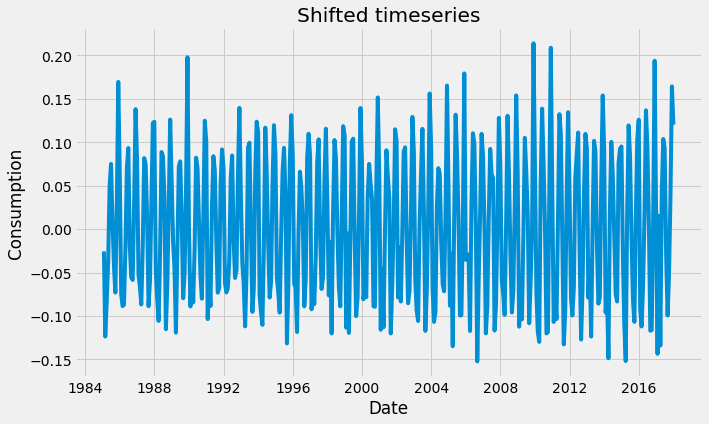

In [10]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)
#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

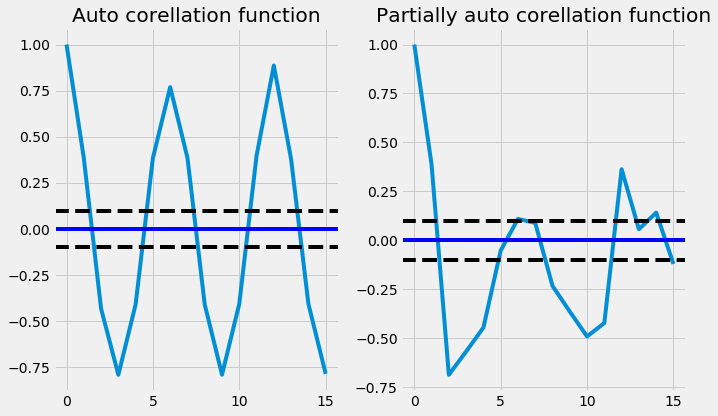

In [11]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')
#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()
#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RSS : 0.522728


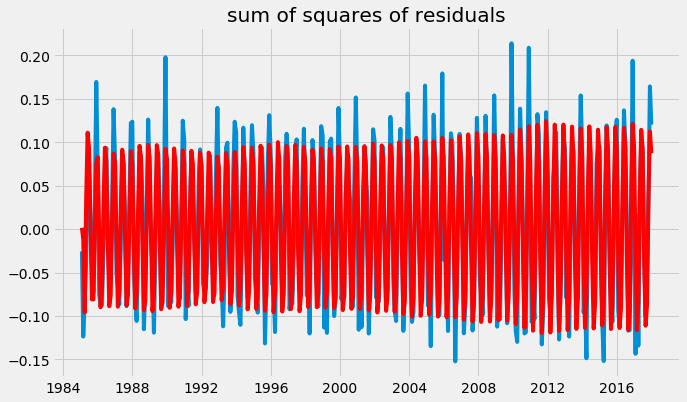

In [18]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(3,1,3))
result_AR = model.fit(disp = 0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))

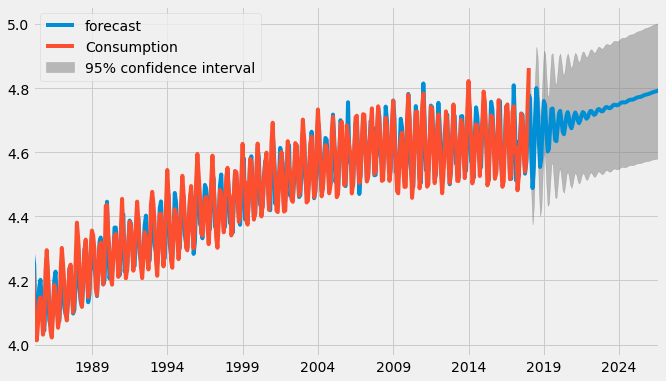

In [17]:
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)